# ASHRAE Kaggle Challenge

<a href='#1'>1. Introduction</a>

<a href='#2'>3. Combining Datasets</a>

<a href='#3'>4. Memory Limitation</a>

<a href='#4'>5. Missing Values</a>

<a href='#5'>6.EDA</a>

<a href='#6'>7. Model Training</a>

<a href='#7'>8. Model Predictions and Kaggle Submission</a>

# <a id='2'>1. Introduction</a>

**Quelle sera la consommation d'un bâtiment ?** C'est la question que pose ce challenge et donc celle à laquelle nous tenterons de répondre le plus précisément possible (la mesure de précision utilisée est la *RMSLE*, *Root Mean Square Logarithmic Error*).

Selon le ministère de la transition écologique, qui est en charge de l'établissement du calcul de diagnostique de performance écologique (*DPE*) des bâtiments et logements en France, les consommations réelles des bâtiments dépendent très directement des conditions d’usage et de la température effective de chauffage ; les consommations estimées ne sont pas une garantie contractuelle, mais elles permettent une comparaison objective de la qualité des logements et bâtiments mis en vente ou loués.

Fort heureusement nous disposons de plusieurs datasets nous renseignant sur les bâtiments étudiés :

In [1]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sn
import statistics
import gc
# from fastai.tabular.core import df_shrink

In [50]:
#load data
train = pd.read_csv('kaggle/input/ashrae-energy-prediction/train.csv', memory_map=True)
train['timestamp'] = pd.to_datetime(train['timestamp']) #the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
test = pd.read_csv('kaggle/input/ashrae-energy-prediction/test.csv', memory_map=True)
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_train.csv', memory_map=True)
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_test.csv', memory_map=True)
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp']) 
build_meta = pd.read_csv('kaggle/input/ashrae-energy-prediction/building_metadata.csv', memory_map=True)

In [51]:
len(train), len(test)

(20216100, 41697600)

Exécuter les lignes de la cellule suivante pour obtenir un échantillon :

In [52]:
# train = train.sample(frac = 0.0005)
# test = test.sample(frac = 0.0005)

In [53]:
train.shape

(20216100, 4)

In [54]:
test.shape

(41697600, 4)

# <a id='2'>2. Combining Datasets</a>
Nous allons rassembler tous les datasets en seulement 2 jeux de données train et test.

In [55]:
weather_test.timestamp = pd.to_datetime(weather_test.timestamp) #pour la compatibilité avec les autres jeux de données
weather_train.timestamp = pd.to_datetime(weather_train.timestamp) 

In [56]:
#merge
train_m = train.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
test_m = test.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
train_m = train_m.merge(weather_train, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
test_m = test_m.merge(weather_test, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
del build_meta, weather_train, weather_test

gc.collect() #pour limiter l'espace utilisé
train_m.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [57]:
del train, test

# <a id='3'>3. Memory Limitation</a>

In [58]:
# from fastai.tabular.core import df_shrink
# start_mem = train_m.memory_usage().sum() / 1024**2
# train_m = df_shrink(train_m,skip=['meter_reading'])
# end_mem = train_m.memory_usage().sum() / 1024**2
# print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

# start_mem = train_m.memory_usage().sum() / 1024**2
# test_m = test_m.astype(train_m.drop(['meter_reading'],axis=1).dtypes)
# end_mem = train_m.memory_usage().sum() / 1024**2
# print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

In [59]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_m = reduce_mem_usage(train_m)
test_m = reduce_mem_usage(test_m)

Mem. usage decreased to 1041.10 Mb (60.3% reduction)
Mem. usage decreased to 2147.36 Mb (60.3% reduction)


# <a id='5'>5. EDA</a>

In [60]:
# mat_coorr=train_m.corr()
# sn.heatmap(mat_coorr)
# plt.show()

Pas de corrélation particulière entre `meter_reading` et les autres variables. Il y a cependant quelques corrélations entre certaines variables comme `floor_count` et `square_feet` ou `air_temperature` et `dew_temperature`. nous les traiterons plus tard pour voir si ces corrélations ont une influence sur nos modèles. 

In [61]:
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook

In [62]:
# is_na=train_m.isnull().sum()*100/train_m.shape[0]
# is_na=is_na.sort_values()
# ind = np.arange(len(is_na))

In [63]:
# from bokeh.models import HoverTool, Legend, LegendItem, Range1d, ColumnDataSource,  RangeTool,  Select, MultiSelect
# from bokeh.transform import linear_cmap
# from bokeh.palettes import RdYlGn11 as palette
# from bokeh.models import LinearAxis
# from bokeh.models import HoverTool, Legend, LegendItem, Range1d, ColumnDataSource,  RangeTool,  Select, MultiSelect

# p = figure(width = 600, height = 300)
# source = ColumnDataSource(data=dict(x=ind, y=is_na.values, xname = is_na.index.to_list()))

In [64]:
# color_mapper = linear_cmap(palette=palette, low=0, high=100, field_name='y')

# hist1 = p.vbar(x='x', top = 'y' , width=1,  source=source, line_color=color_mapper, fill_color = color_mapper, name = "Histogramme",alpha=0.6)

# h = HoverTool( # code pour l'outil qui affiche les informations de la courbe en passant la souris dessus
#     tooltips=[
#         ('Variable', '@xname'),
#         ('Pourcentage de NA', '$y'),#pour obtenir le nom de la courbe sur laquelle se trouve le pointeur
#     ],
#     renderers = [hist1]#, j]
# )
# p.add_tools(h)


# #show(p)

In [65]:
# plt.bar(ind, is_na.values)
# plt.xticks(ind,is_na.index,rotation=90)
# plt.ylabel("Pourcentage de NA")
# plt.show()

Les labels `floor_count` et `year_built` sont ceux pour lesquels il y a le plus de NA. C'est dommage car ce sont des indexs qui intuitivement auront beaucoup d'influence sur l'energie consommée.

In [66]:
# train_m['hour_datetime'] = train_m['timestamp'].dt.hour.astype(np.int8)  
# train_m['day_week'] = train_m['timestamp'].dt.dayofweek.astype(np.int8)

In [67]:
# p2 = figure(width = 600, height = 300)
# p3 = figure(width = 600, height = 300)#,x_axis_type = 'datetime')
# # source2 = ColumnDataSource(data=dict(x=ind, y=is_na.values, xname = is_na.index.to_list()))
# # p.line(df['Date'], df.vol.mul(df.vol), line_width = 3, name= 'données réelles', color = 'purple')
# # p2.line(train_m.hour_datetime, train_m.meter_reading, line_width = 2, color='black', name = 'Par heure')
# p2.line(train_m.groupby('hour_datetime').hour_datetime.mean(), train_m[['hour_datetime', 'meter_reading']].groupby('hour_datetime').meter_reading.mean(), line_width = 2, color='red', name = 'Meter reading par heure')

# legend_list = []
# for i in range(len(p2.renderers)):
#         leg_tmp = LegendItem(label=p2.renderers[i].name, renderers = [p2.renderers[i]])
#         legend_list.append(leg_tmp)
# legend = Legend(items=legend_list, location='top_right')
# p2.add_layout(legend)

# # show(p2)

# p3.line(train_m.groupby('day_week').day_week.mean(), train_m[['day_week', 'meter_reading']].groupby('day_week').meter_reading.mean(), line_width = 2, color='red', name = 'Meter reading par jour')


# legend_list = []
# for i in range(len(p3.renderers)):
#         leg_tmp = LegendItem(label=p3.renderers[i].name, renderers = [p3.renderers[i]])
#         legend_list.append(leg_tmp)
# legend = Legend(items=legend_list, location='top_right')
# p3.add_layout(legend)




# show(p3)

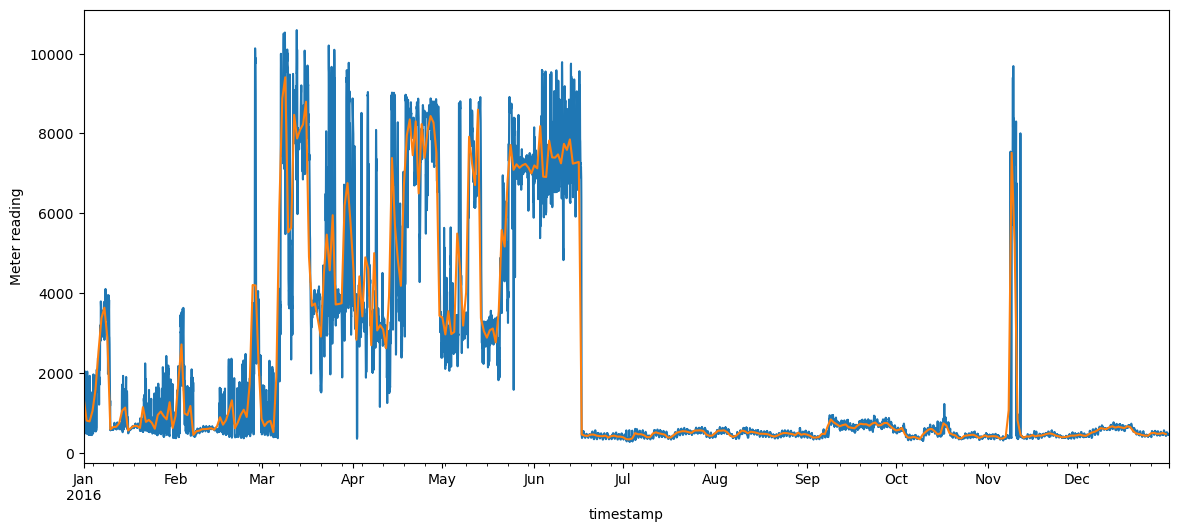

In [68]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
# axes.set_title('Metre relevé moyen par jour et par heure');
# axes.legend();
# plt.show()

La forme de la distribution de la valeur cible dans le temps est plutôt étrange. On observe des pics irréguliers. Regardons de plus près.

In [69]:
# import warnings
# warnings.filterwarnings("ignore")

In [70]:
# fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_pu=list(train_m['primary_use'].value_counts().index);
# for i in range(len(list_pu)):
#     train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
#     train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
#     axes[i%8][i//8].legend();
#     axes[i%8][i//8].set_title(list_pu[i]);
#     plt.subplots_adjust(hspace=0.45)
# plt.show()

Notre problème se situe dans Education.

In [71]:
# fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_sid=list(train_m['site_id'].value_counts().index);
# train_hist=train_m[train_m['primary_use'] == 'Education']
# for i in range(len(list_sid)):
#     try :
#         train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
#         train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
#         axes[i%8][i//8].legend();
#     except :
#         pass
#     axes[i%8][i//8].set_title(i);
#     plt.subplots_adjust(hspace=0.45)
# plt.show()
# del train_hist;

Notre problème se situe dans le 13.

In [72]:
# fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
# train_hist=train_m[train_m['primary_use'] == 'Education']
# train_hist2=train_hist[train_hist['site_id'] == 13]
# list_met=list(train_hist2['meter'].value_counts().index);
# for i in range(len(list_met)):
#     try :
#         train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], label='Par heure').set_ylabel('Metre relevé moyen');
#         train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i],  label='Par jour').set_xlabel('');
#         axes[i].legend();
#     except TypeError:
#         pass
#     axes[i].set_title(list_met[i]);
#     plt.subplots_adjust(hspace=0.45)
# plt.show()
# del train_hist;
# del train_hist2;

Le problème se situe dans le metre de type 2.

In [73]:
# fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
# train_hist=train_m[train_m['primary_use'] == 'Education']
# train_hist2=train_hist[train_hist['site_id'] == 13]
# train_hist3=train_hist2[train_hist2['meter']==2]
# list_build=list(train_hist3['building_id'].value_counts().index);
# for i in range(len(list_build)):
#     try :
#         train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], label='Par heure').set_ylabel('Metre relevé moyen');
#         train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9],  label='Par jour').set_xlabel('');
#         axes[i%9][i//9].legend();
#     except TypeError:
#         pass
#     axes[i%9][i//9].set_title(list_build[i]);
#     plt.subplots_adjust(hspace=0.45)
# plt.show()
# del train_hist;
# del train_hist2;
# del train_hist3;

In [74]:
# fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
# train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
# train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
# axes.set_title('Metre relevé moyen par jour et par heure');
# axes.legend();
# plt.show()

In [75]:
# fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
new_train=train_m[train_m['building_id'] != 1099]
# new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
# new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
# axes.set_title('Metre relevé moyen par jour et par heure');
# axes.legend();
# plt.show()

In [76]:
new_test=test_m
new_test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [77]:
del train_m
del test_m
gc.collect()

5844

Remplacement NA

In [78]:
# for i in list_pu:
#     print(i)
#     print(new_train[new_train['primary_use']==i].isnull().sum()*100/new_train[new_train['primary_use']==i].shape[0])
#     print("")

`Services`, `Food sales and service`, `Religious worship` n'ont aucune donnée pour la variable `floor_count`. Nous allons d'abord combler ce qu'il manque dans les autres catégories par la moyenne. 

In [79]:
# new_train.isnull().sum()*100/new_train.shape[0]

In [80]:
# new_test.isnull().sum()*100/new_test.shape[0]

In [81]:
import statistics
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)        


In [82]:
for i in range(len(list_pu)):
    if (list_pu[i]!="Services") & (list_pu[i]!="Food sales and service") & (list_pu[i]!="Religious worship") :
        new_train.loc[new_train.primary_use==list_pu[i],['floor_count']]=new_train[new_train['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['floor_count']]=new_test[new_test['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean_test[i])
new_train.head()
gc.collect()

0

In [83]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [84]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['floor_count']]=new_train[new_train['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['floor_count']]=new_test[new_test['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean_test[i])
new_train.head()
gc.collect()

0

In [85]:
# new_train.isnull().sum()*100/new_train.shape[0]

In [86]:
# new_test.isnull().sum()*100/new_test.shape[0]

C'est bon pour `floor_count`, au tour de `year_built`

In [87]:
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)

In [88]:
for i in range(len(list_pu)):
    if list_pu[i]!="Services":
        new_train.loc[new_train.primary_use==list_pu[i],['year_built']]=new_train[new_train['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['year_built']]=new_test[new_test['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean_test[i])
new_train.head()
gc.collect()

22

In [89]:
# new_train.isnull().sum()*100/new_train.shape[0]

In [90]:
# new_test.isnull().sum()*100/new_test.shape[0]

In [91]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [92]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['year_built']]=new_train[new_train['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['year_built']]=new_test[new_test['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [93]:
# new_train.isnull().sum()*100/new_train.shape[0]

In [94]:
# new_test.isnull().sum()*100/new_test.shape[0]

Pour les infos météo, on se base seulement selon le site. Se baser sur `primary_use` n'aurait pas de sens pour ce type de donnée.

In [95]:
# for i in list_sid:
#     print(i)
#     print(new_train[new_train['site_id']==i].isnull().sum()*100/new_train[new_train['site_id']==i].shape[0])
#     print("")

In [96]:
#cloud coverage
#site id 7, 11 n'ont aucune donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    if (list_sid[i] != 7) & (list_sid[i] != 11):
        new_train.loc[new_train.site_id==list_sid[i],['cloud_coverage']]=new_train[new_train['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['cloud_coverage']]=new_test[new_test['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875


In [97]:
# new_train.isnull().sum()*100/new_train.shape[0] #il reste 2% de cloud_coverage inconnu

In [98]:
# new_test.isnull().sum()*100/new_test.shape[0]

In [99]:
#precip_depth_1_hr
#12, 5, 1 n'ont pas de donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in list_sid:
    temp=new_test[new_test['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)
        
for i in range(len(list_sid)):
    if (list_sid[i] != 12) & (list_sid[i] != 5) & (list_sid[i] != 1):
        new_train.loc[new_train.site_id==list_sid[i],['precip_depth_1_hr']]=new_train[new_train['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['precip_depth_1_hr']]=new_test[new_test['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean_test[i])
new_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0


In [100]:
# new_train.isnull().sum()*100/new_train.shape[0] #il reste 8% d'inconnu pour precip_depth_1_hr

In [101]:
# new_test.isnull().sum()*100/new_test.shape[0]

In [102]:
#sea_lever_pressure
#le site 5 n'a aucune donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    if list_sid[i] != 5:
        new_train.loc[new_train.site_id==list_sid[i],['sea_level_pressure']]=new_train[new_train['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['sea_level_pressure']]=new_test[new_test['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean_test[i])
new_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0


In [103]:
# new_train.isnull().sum()*100/new_train.shape[0] #il reste 3.8% d'inconnu pour sea_level_pressure

In [104]:
# new_test.isnull().sum()*100/new_test.shape[0]

In [105]:
#air_temperature_v2

temp_train = pd.read_csv('kaggle/input/temperature.csv')
temp_train['datetime'] = pd.to_datetime(temp_train['datetime']) #the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
temp_test = pd.read_csv('kaggle/input/filled_weather_test.csv')
temp_test.timestamp = pd.to_datetime(temp_test.timestamp, format='%Y-%m-%d %H:%M:%S')

temp_train.set_index('datetime',inplace=True)
temp_train=temp_train.subtract(273.15)
temp_train.index.names=['timestamp']
temp_test.set_index('timestamp',inplace=True)

villes=['Jacksonville','NA','Phoenix','Philadelphia','San Francisco','NA','Philadelphia','Montreal','Jacksonville','San Antonio','Las Vegas','Montreal','NA','Minneapolis','Philadelphia','Toronto']

j=0
for i in villes:
    if i!='NA':
        index=new_train[new_train['site_id']==j][['timestamp','air_temperature']].index
        temp=new_train[new_train['site_id']==j][['timestamp','air_temperature']].set_index('timestamp')
        temp[temp.air_temperature.isnull()]=temp_train[[i]]     
        temp=temp.set_index(index)
        new_train.loc[new_train.site_id==j,'air_temperature']=temp
    j+=1

for i in range(16):
    index=new_test[new_test['site_id']==i][['timestamp','air_temperature']].index
    temp=new_test[new_test['site_id']==i][['timestamp','air_temperature']].set_index('timestamp')
    temp[temp.air_temperature.isnull()]=temp_test[[str(i)]] 
    new_test.loc[new_test.site_id==i,'air_temperature']=temp.set_index(index)

In [106]:
del temp_train, temp_test, temp

gc.collect()
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['air_temperature']]=new_train[new_train['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['air_temperature']]=new_test[new_test['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean_test[i])
new_train.isnull().sum()*100/new_train.shape[0]
gc.collect()

0

In [107]:
#dew_temperature
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['dew_temperature']]=new_train[new_train['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['dew_temperature']]=new_test[new_test['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean_test[i])

# new_train.isnull().sum()*100/new_train.shape[0]

In [108]:
#wind_direction
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in list_sid:
    temp=new_test[new_test['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_direction']]=new_train[new_train['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['wind_direction']]=new_test[new_test['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean_test[i])

# new_train.isnull().sum()*100/new_train.shape[0]

In [109]:
#wind_speed
list_sid_mean=[]
list_sid_mean_test=[]

for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_speed']]=new_train[new_train['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['wind_speed']]=new_test[new_test['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean_test[i])

# new_train.isnull().sum()*100/new_train.shape[0]

In [110]:
# new_test.isnull().sum()*100/new_test.shape[0]

Pour bien terminer le travail, et finir de remplir les derniers NA, il faudrait comparer les données météo pour retrouver les villes des différents sites et récupérer les données. On pourrait même remplacer les données moyennes ajoutées aux données météo par les valeurs réelles trouvées.

In [111]:
#FE
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

new_train['date'] = new_train.timestamp.dt.date
new_train ['heure'] = new_train.timestamp.dt.hour
new_train ['mois'] = new_train.timestamp.dt.month
new_train ['joursemaine'] = new_train.timestamp.dt.dayofweek

#cal = calendar()
#vac = cal.holidays(start=new_train.timestamp.min(), end=new_train.timestamp.max())
#new_train['EstVac'] = new_train['timestamp'].isin(vac)

new_test['date'] = new_test.timestamp.dt.date
new_test['heure'] = new_test.timestamp.dt.hour
new_test['mois'] = new_test.timestamp.dt.month
new_test['joursemaine'] = new_test.timestamp.dt.dayofweek

#cal = calendar()
#vac = cal.holidays(start=new_test.timestamp.min(), end=new_test.timestamp.max())
#new_test['EstVac'] = new_test['timestamp'].isin(vac)
gc.collect()

132

In [112]:
new_train.primary_use = new_train.primary_use.astype('category')
new_test.primary_use = new_test.primary_use.astype('category')

In [113]:
train_df=new_train.dropna(axis='columns')
test_df=new_test.dropna(axis='columns')

In [114]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_df['primary_use']) #encode en one hot les variables non numériques qualitatives
train_df['primary_use']=le.transform(train_df['primary_use'])
test_df['primary_use']=le.transform(test_df['primary_use'])
train_df['date']=pd.to_numeric(pd.to_datetime(train_df['date']))
test_df['date']=pd.to_numeric(pd.to_datetime(test_df['date']))
train_df = train_df.drop('timestamp', axis = 1)
test_df = test_df.drop('timestamp', axis = 1)

<ipython-input-114-e43094aba614>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['primary_use']=le.transform(train_df['primary_use'])
<ipython-input-114-e43094aba614>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['primary_use']=le.transform(test_df['primary_use'])
<ipython-input-114-e43094aba614>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [115]:
del new_train
del new_test
gc.collect()

22

In [116]:
test_df.shape

(41697600, 16)

In [117]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 847.56 Mb (35.3% reduction)
Mem. usage decreased to 1749.70 Mb (35.3% reduction)


In [118]:
train_df.to_pickle('kaggle/input/ashrae-energy-prediction/train_df.pkl')
del train_df

In [119]:
test_df.to_pickle('kaggle/input/ashrae-energy-prediction/test_df.pkl')
del test_df

gc.collect()

88

# <a id='6'>6. Model Training</a>

### Data Preparation

In [2]:
train_df = pd.read_pickle('kaggle/input/ashrae-energy-prediction/train_df.pkl')

In [3]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,wind_direction,wind_speed,date,heure,mois,joursemaine
0,0,0,0.0,0,0,7432,2008.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4
1,1,0,0.0,0,0,2720,2004.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4
2,2,0,0.0,0,0,5376,1991.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4
3,3,0,0.0,0,0,23685,2002.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4
4,4,0,0.0,0,0,116607,1975.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4


In [4]:
train_df = train_df.sample(random_state=123,frac=0.05) #pour la selection du modèle, nous ne prenons qu'un sous-échantillon du dataset pour des itérations plus rapides

X = train_df.drop(['meter_reading'],axis=1)
y = train_df['meter_reading']

del train_df
gc.collect()

22

### Models

#### Evaluation

In [5]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer,mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

def rmsle(y_test, predictions): #seul objectif de la compétition
    return np.sqrt(mean_squared_log_error( y_test, predictions )) #np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

rmsle_score = make_scorer(rmsle)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = lambda model : cross_val_score(model, X, y, scoring=rmsle_score, cv=cv, n_jobs=-1,verbose=2)

#### Decision Tree

In [6]:
from sklearn.tree import DecisionTreeRegressor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>15 1.357 (0.013)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>20 0.996 (0.009)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>30 0.935 (0.009)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>40 0.944 (0.009)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>50 0.944 (0.009)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>70 0.944 (0.009)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


>90 0.945 (0.009)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>120 0.945 (0.008)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


>150 0.945 (0.009)


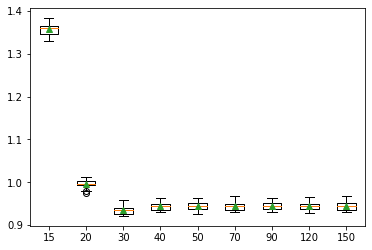

In [7]:
def get_models():
	models = dict()
	# define the number of trees to consider
	max_depth = [15,20,30,40,50,70,90,120,150]
	for v in max_depth:
		models[str(v)] = DecisionTreeRegressor(max_depth=v)
	return models

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = n_scores(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
def get_models():
	models = dict()
	# define the number of trees to consider
	criterion = ["mse", "friedman_mse", "mae", "poisson"]
	for v in criterion:
		models[str(v)] = DecisionTreeRegressor(criterion=v,max_depth=30)
	return models

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = n_scores(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>mse 0.934 (0.009)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>friedman_mse 0.934 (0.009)


#### Bagging

##### Sklearn Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
def get_models():
	models = dict()
	for v in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % v
		models[key] = BaggingRegressor(max_samples=i)
	return models

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = n_scores(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

##### Random Forest avec XGBoost

In [ ]:
from xgboost import XGBRFRegressor

Nous cherchons d'abord un nombre d'arbres optimal :

In [ ]:
def get_models():
	models = dict()
	# define the number of trees to consider
	n_trees = [10, 50, 100, 500, 1000, 5000]
	for v in n_trees:
		models[str(v)] = XGBRFRegressor(n_estimators=v, subsample=0.9, colsample_bynode=0.2)
	return models

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the results
	scores = n_scores(model)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Puis le nombre de features à garder par arbre :

In [ ]:
def get_models():
	models = dict()
	for v in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % v
		models[key] = XGBRFRegressor(n_estimators=100, subsample=0.9, colsample_bynode=v)
	return models

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the results
	scores = n_scores(model)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### Boosting

In [ ]:
from xgboost import XGBRegressor

In [ ]:
def get_models():
	models = dict()
	trees = [10, 50, 100, 500, 1000, 5000]
	for n in trees:
		models[str(n)] = XGBRegressor(n_estimators=n)
	return models

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = n_scores(model)
	# stores the results
	results.append(scores)
	names.append(name)
	# report performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
def get_models():
	models = dict()
	for i in range(1,11):
		models[str(i)] = XGBRegressor(max_depth=i)
	return models

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = n_scores(model)
	# stores the results
	results.append(scores)
	names.append(name)
	# report performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
def get_models():
	models = dict()
	rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
	for r in rates:
		key = '%.4f' % r
		models[key] = XGBRegressor(eta=r)
	return models

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = n_scores(model)
	# stores the results
	results.append(scores)
	names.append(name)
	# report performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
def get_models():
	models = dict()
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = XGBRegressor(subsample=i)
	return models

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = n_scores(model)
	# stores the results
	results.append(scores)
	names.append(name)
	# report performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
def get_models():
	models = dict()
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = XGBRegressor(colsample_bytree=i)
	return models

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = n_scores(model)
	# stores the results
	results.append(scores)
	names.append(name)
	# report performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### Blending

In [ ]:
from numpy import hstack
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LinearRegression()))
	models.append(('knn', KNeighborsRegressor()))
	models.append(('cart', DecisionTreeRegressor()))
	models.append(('svm', SVR()))
	return models

# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LinearRegression()))
	models.append(('knn', KNeighborsRegressor()))
	models.append(('cart', DecisionTreeRegressor()))
	models.append(('svm', SVR()))
	return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
	for name, model in models:
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		yhat = model.predict(X_val)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# define blending model
	blender = LinearRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# predict
	return blender.predict(meta_X)

# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=1)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions
score = rmsle(y_test, yhat)
print('Blending RMSLE: %.3f' % score)

Now that we have tuned the model parameters and have an idea of model performance. We will fit on the entire training dataset so we have as much information as possible for the final test set prediction.

# <a id='7'>7. Model Predictions and Kaggle Submission</a>

Pour de meilleures prédiction nous allons entraîner le modèle le jugé le plus performant sur le maximum de données à notre disposition.

In [76]:
train_df = pd.read_pickle('kaggle/input/ashrae-energy-prediction/train_df.pkl')
train_df = train_df.sample(random_state=123,frac=0.6)
X = train_df.drop(['meter_reading'],axis=1)
y = train_df['meter_reading']

del train_df
gc.collect()

22

In [77]:
choosen_one = 'xgb'#le model avec lequel on souhaite faire les prédictions

if choosen_one == 'tree':
    tree_rg = DecisionRegressor(min_samples_lead=2000)
    tree_rg.fit(X,y)
if choosen_one == 'bg':
    bg_rg = BaggingRegressor(max_samples=1.0,verbose=3)
    bg_rg.fit(X,y)
if choosen_one == 'rf':
    rf_rg = XGBRFRegressor(n_estimators=10, subsample=0.9, colsample_bynode=0.7)
    rf_rg.fit(X,y)
if choosen_one == 'xgb':
    xgb_rg = XGBRegressor()
    xgb_rg.fit(X,y)

In [78]:
#obtention des prédictions et du fichier à évaluer 
del X,y
gc.collect()

test_df = pd.read_pickle('kaggle/input/ashrae-energy-prediction/test_df.pkl')
X_test = test_df.drop('row_id',axis=1)
X_test.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,wind_direction,wind_speed,date,heure,mois,joursemaine
0,0,0,0,0,7432,2008.0,5.203125,17.796875,11.703125,100.0,3.599609,1483228800000000000,0,1,6
1,1,0,0,0,2720,2004.0,5.203125,17.796875,11.703125,100.0,3.599609,1483228800000000000,0,1,6
2,2,0,0,0,5376,1991.0,5.203125,17.796875,11.703125,100.0,3.599609,1483228800000000000,0,1,6
3,3,0,0,0,23685,2002.0,5.203125,17.796875,11.703125,100.0,3.599609,1483228800000000000,0,1,6
4,4,0,0,0,116607,1975.0,5.203125,17.796875,11.703125,100.0,3.599609,1483228800000000000,0,1,6


In [79]:
gc.collect()
gc.collect()

0

In [80]:
y_test_predict=xgb_rg.predict(X_test)

In [81]:
my_submission = pd.DataFrame({'row_id': test_df.index, 'meter_reading': y_test_predict})
my_submission.to_csv('submission_f.csv', index=False)

In [82]:
my_submission.shape

(41697600, 2)

In [83]:
del y_test_predict, my_submission, X_test, test_df
gc.collect()

97